# Import Statements

In [ ]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2

# Apply the default theme
sns.set_theme()

# CD to directory

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
cd /content/gdrive/MyDrive/dl_Small_Project/

/content/gdrive/.shortcut-targets-by-id/1i4EWnD3rTI49D40fIp4sdj2kEFPc1E1w/dl_Small_Project


# Dataset familiarisation and Setting of Dataset Paths

In [ ]:
# Number of images in each part of the dataset
dataset_numbers = {'train_normal': 1341,\
                   'train_infected_non-covid': 2530,\
                   'train_infected_covid' : 1345,\
                   #'val_normal': 8,\
                   #'val_infected_non-covid': 8,\
                   #'val_infected_covid': 8, \
                   'test_normal': 234,\
                   'test_infected_non-covid': 242,\
                   'test_infected_covid': 138}
print(dataset_numbers)

{'train_normal': 1341, 'train_infected_non-covid': 2530, 'train_infected_covid': 1345, 'test_normal': 234, 'test_infected_non-covid': 242, 'test_infected_covid': 138}


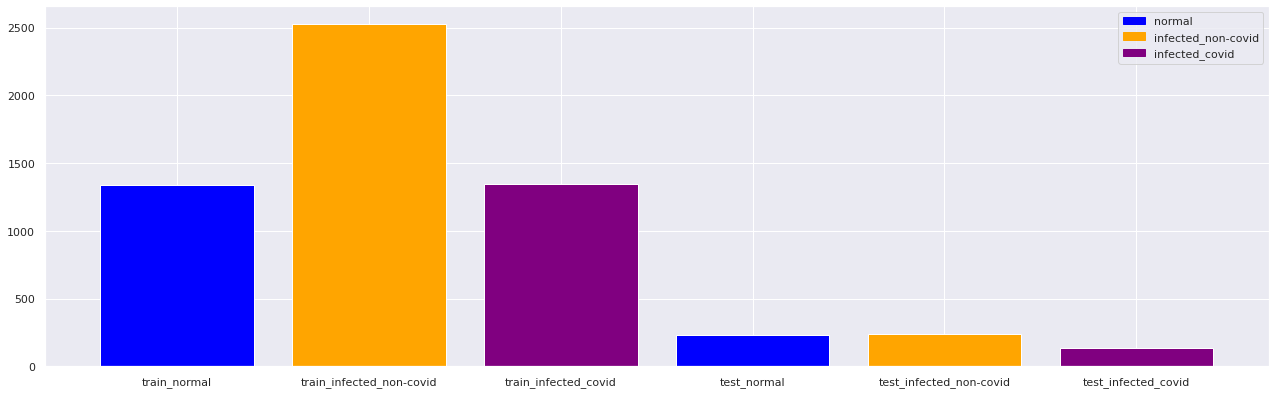

In [ ]:
# Data distribution graph for Normal vs Non-Covid vs Covid
fig = plt.figure(figsize=([17, 5]))
ax = fig.add_axes([0,0,1,1])
dataset_names = dataset_numbers.keys()
dataset_counts = dataset_numbers.values()
ax.bar(dataset_names, dataset_counts, color=['blue', 'orange', 'purple', 'blue', 'orange', 'purple'])

colors = {'normal': 'blue', 'infected_non-covid': 'orange', 'infected_covid': 'purple'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

The above graph shows the data distribution for normal, infected_non-covid and infected_covid samples. On the train side, we see that the majority class is the infected_non-covid class which is about 2x bigger than both the normal and infected_covid samples. On the test set we only see a minor imbalance where normal and infected_non-covid are about equal in size and infected_covid is about 0.5x the size of the other two classes.

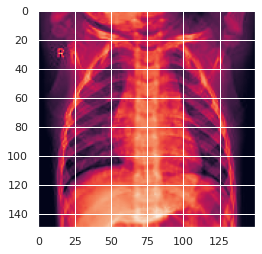

In [ ]:
# Display an image
path_to_file = './dataset/train/normal/1.jpg'
with open(path_to_file, 'rb') as f:
    im = np.asarray(Image.open(f))
    plt.imshow(im)
f.close()

# Creating a train Dataset object

In [ ]:
class Lung_Train_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected_non-covid', 2: 'infected_covid'}
        
        # The dataset consists only of training images
        self.groups = 'train'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 1341,\
                                'train_infected_non-covid': 2530,\
                                'train_infected_covid': 1345}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                              'train_infected_non-covid': './dataset/train/infected/non-covid/',\
                              'train_infected_covid': './dataset/train/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Resize to make sure all imgs standardised dim
            im = cv2.resize(np.asarray(Image.open(f)), self.img_size)
            # Remove img noise
            im = cv2.GaussianBlur(im, (5,5), 0)
            # Normalize data
            im = im/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index < first_val + second_val:
            class_val = 'infected_non-covid'
            index = index - first_val 
            label = torch.Tensor([0, 1, 0])
        else: 
            class_val = 'infected_covid'
            index = index - first_val - second_val
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

### Test Statements

In [ ]:
ld_train = Lung_Train_Dataset()
ld_train.describe()

This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected_non-covid, in folder ./dataset/train/infected/non-covid/: 2530 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid/: 1345 images.



In [ ]:
print(len(ld_train))

5216


In [ ]:
# train_normal test
im, class_oh = ld_train[64]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([1., 0., 0.])


In [ ]:
# train_infected_non-covid test
im, class_oh = ld_train[1341]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0902, 0.0980, 0.1137,  ..., 0.0510, 0.0314, 0.0275],
         [0.0902, 0.1020, 0.1176,  ..., 0.0510, 0.0353, 0.0275],
         [0.1020, 0.1098, 0.1255,  ..., 0.0549, 0.0353, 0.0314],
         ...,
         [0.0392, 0.0353, 0.0275,  ..., 0.0588, 0.0588, 0.0588],
         [0.0392, 0.0353, 0.0275,  ..., 0.0588, 0.0588, 0.0588],
         [0.0392, 0.0353, 0.0275,  ..., 0.0588, 0.0588, 0.0588]]])
tensor([0., 1., 0.])


In [ ]:
# train_infected_covid test
im, class_oh = ld_train[5000]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.1608, 0.1686, 0.1804,  ..., 0.1647, 0.1804, 0.1922],
         [0.1608, 0.1647, 0.1804,  ..., 0.1647, 0.1725, 0.1804],
         [0.1569, 0.1608, 0.1725,  ..., 0.1686, 0.1647, 0.1647],
         ...,
         [0.0902, 0.0863, 0.0824,  ..., 0.3608, 0.4902, 0.5412],
         [0.0902, 0.0863, 0.0824,  ..., 0.3804, 0.5020, 0.5490],
         [0.0902, 0.0863, 0.0824,  ..., 0.3843, 0.5059, 0.5490]]])
tensor([0., 0., 1.])


# Creating a test Dataset object

In [ ]:
class Lung_Test_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected_non-covid', 2: 'infected_covid'}
        
        # The dataset consists only of test images
        self.groups = 'test'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'test_normal': 234,\
                                'test_infected_non-covid': 242,\
                                'test_infected_covid': 138}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'test_normal': './dataset/test/normal/',\
                              'test_infected_non-covid': './dataset/test/infected/non-covid/',\
                              'test_infected_covid': './dataset/test/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the test dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'test'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'test'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Resize to make sure all imgs standardised dim
            im = cv2.resize(np.asarray(Image.open(f)), self.img_size)
            # Remove img noise
            im = cv2.GaussianBlur(im, (5,5), 0)
            # Normalize data
            im = im/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'test'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index < first_val + second_val:
            class_val = 'infected_non-covid'
            index = index - first_val 
            label = torch.Tensor([0, 1, 0])
        else: 
            class_val = 'infected_covid'
            index = index - first_val - second_val
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

### Test Statements

In [ ]:
ld_test = Lung_Test_Dataset()
ld_test.describe()

This is the test dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 614 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_normal, in folder ./dataset/test/normal/: 234 images.
 - test_infected_non-covid, in folder ./dataset/test/infected/non-covid/: 242 images.
 - test_infected_covid, in folder ./dataset/test/infected/covid/: 138 images.



In [ ]:
im, class_oh = ld_test[18]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.0235, 0.0235, 0.0235],
         [0.0118, 0.0118, 0.0118,  ..., 0.0235, 0.0235, 0.0235],
         [0.0118, 0.0118, 0.0118,  ..., 0.0235, 0.0235, 0.0235],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196]]])
tensor([1., 0., 0.])


In [ ]:
im, class_oh = ld_test[234]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0667, 0.0784, 0.1020,  ..., 0.3725, 0.3529, 0.3451],
         [0.0667, 0.0745, 0.1020,  ..., 0.3686, 0.3490, 0.3412],
         [0.0627, 0.0706, 0.0980,  ..., 0.3608, 0.3373, 0.3294],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000]]])
tensor([0., 1., 0.])


In [ ]:
im, class_oh = ld_test[500]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.2118, 0.1843, 0.1686],
         [0.0039, 0.0039, 0.0039,  ..., 0.2549, 0.2314, 0.2157],
         [0.0078, 0.0039, 0.0039,  ..., 0.3255, 0.3020, 0.2941],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.2667, 0.2471, 0.2353],
         [0.0000, 0.0000, 0.0000,  ..., 0.1765, 0.1647, 0.1569],
         [0.0000, 0.0000, 0.0000,  ..., 0.1216, 0.1176, 0.1137]]])
tensor([0., 0., 1.])


# Creating a Val Dataset object

In [ ]:
class Lung_Val_Dataset(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected_non-covid', 2: 'infected_covid'}
        
        # The dataset consists only of test images
        self.groups = 'val'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'val_normal': 8,\
                                'val_infected_non-covid': 8,\
                                'val_infected_covid': 8}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'val_normal': './dataset/val/normal/',\
                              'val_infected_non-covid': './dataset/val/infected/non-covid/',\
                              'val_infected_covid': './dataset/val/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the test dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'val'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Resize to make sure all imgs standardised dim
            im = cv2.resize(np.asarray(Image.open(f)), self.img_size)
            # Remove img noise
            im = cv2.GaussianBlur(im, (5,5), 0)
            # Normalize data
            im = im/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'val'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index < first_val + second_val:
            class_val = 'infected_non-covid'
            index = index - first_val 
            label = torch.Tensor([0, 1, 0])
        else: 
            class_val = 'infected_covid'
            index = index - first_val - second_val
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

### Test Statements

In [ ]:
ld_val = Lung_Val_Dataset()
ld_val.describe()

This is the test dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 24 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_normal, in folder ./dataset/val/normal/: 8 images.
 - val_infected_non-covid, in folder ./dataset/val/infected/non-covid/: 8 images.
 - val_infected_covid, in folder ./dataset/val/infected/covid/: 8 images.



In [ ]:
print(len(ld_val))

24


In [ ]:
im, class_oh = ld_val[3]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.2078, 0.2353, 0.2706,  ..., 0.0902, 0.0745, 0.0706],
         [0.2275, 0.2549, 0.2941,  ..., 0.0863, 0.0745, 0.0706],
         [0.2706, 0.2941, 0.3333,  ..., 0.0824, 0.0745, 0.0745],
         ...,
         [0.0039, 0.0039, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000]]])
tensor([1., 0., 0.])


In [ ]:
im, class_oh = ld_val[8]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0706, 0.0745, 0.0863,  ..., 0.1059, 0.0863, 0.0784],
         [0.0745, 0.0784, 0.0902,  ..., 0.1216, 0.0980, 0.0902],
         [0.0745, 0.0824, 0.1020,  ..., 0.1490, 0.1255, 0.1137],
         ...,
         [0.0353, 0.0314, 0.0235,  ..., 0.0078, 0.0118, 0.0157],
         [0.0431, 0.0353, 0.0235,  ..., 0.0078, 0.0196, 0.0275],
         [0.0471, 0.0392, 0.0235,  ..., 0.0118, 0.0235, 0.0353]]])
tensor([0., 1., 0.])


In [ ]:
im, class_oh = ld_val[20]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0039, 0.0039, 0.0000,  ..., 0.2431, 0.2392, 0.2275],
         [0.0039, 0.0039, 0.0000,  ..., 0.2157, 0.2118, 0.1961],
         [0.0078, 0.0078, 0.0039,  ..., 0.1569, 0.1529, 0.1412],
         ...,
         [0.2196, 0.2118, 0.1725,  ..., 0.0000, 0.0039, 0.0078],
         [0.2980, 0.2863, 0.2314,  ..., 0.0039, 0.0118, 0.0157],
         [0.3333, 0.3216, 0.2627,  ..., 0.0078, 0.0157, 0.0235]]])
tensor([0., 0., 1.])


# Creating a Dataloader object

In [ ]:
# Batch size value to be used (to be decided freely, but set to 4 for demo)
# bs_val = 8
bs_val = 32

In [ ]:
# Dataloader from dataset (train)
train_loader = DataLoader(ld_train, batch_size = bs_val, shuffle = True)
print(train_loader)

In [ ]:
# Dataloader from dataset (test and val)
test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
print(test_loader)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)
print(val_loader)

In [ ]:
# Typical mini-batch for loop on dataloader (train)
for k, v in enumerate(train_loader):
    print("-----")
    print(k)
    print(v[0])
    print(v[1])
    # Forced stop
    break
    #assert False, "Forced stop after one iteration of the for loop"

-----
0
tensor([[[[0.0392, 0.0431, 0.0510,  ..., 0.2235, 0.2667, 0.2902],
          [0.0431, 0.0471, 0.0588,  ..., 0.2235, 0.2706, 0.2902],
          [0.0471, 0.0549, 0.0667,  ..., 0.2314, 0.2745, 0.2941],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0392, 0.0118, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0431, 0.0118, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0471, 0.0157, 0.0039]]],


        [[[0.1333, 0.1373, 0.1412,  ..., 0.7608, 0.7608, 0.7647],
          [0.1373, 0.1373, 0.1412,  ..., 0.7569, 0.7608, 0.7647],
          [0.1373, 0.1412, 0.1412,  ..., 0.7490, 0.7569, 0.7608],
          ...,
          [0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745]]],


        [[[0.0745, 0.0745, 0.0784,  ..., 0.0627, 0.0588, 0.0549],
          [0.0745, 0.0745, 0.0784,  ..., 0.0627, 0.0549, 0.0510],
          [0.0745, 0.0784, 0.0

# Using our dataloader for training a model

## Complex

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize = False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

training now...
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[ 0., 16.,  0.],
        [ 0.,  8.,  0.],
        [ 0.,  0.,  0.]])
Validation loss: 1.100437879562378
Validation set accuracy:  33.333333333333336 %
Epoch: 1/5 -  Training Loss: 0.011 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[ 1., 15.,  0.],
        [ 0.,  8.,  0.],
        [ 0.,  0.,  0.]])
Validation loss: 2.088624954223633
Validation set accuracy:  37.5 %
Epoch: 1/5 -  Training Loss: 0.766 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[ 0., 16.,  0.],
        [ 0.,  8.,  0.],
        [ 0.,  0.,  0.]])
Validation loss: 2.3715641498565674
Validation set accuracy:  33.333333333333336 %
Epoch: 2/5 -  Training Loss: 0.380 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[3., 5., 8.],
        [4., 2., 2.],
        [0., 0., 0.]])
Validation loss: 0.861649215221405
Validation set accuracy:  62.5 %
Epoch: 2/5 -  Training Loss:

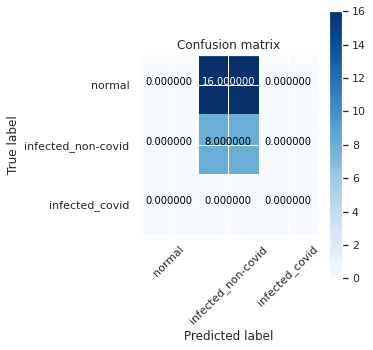

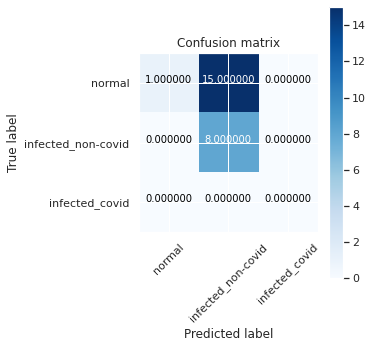

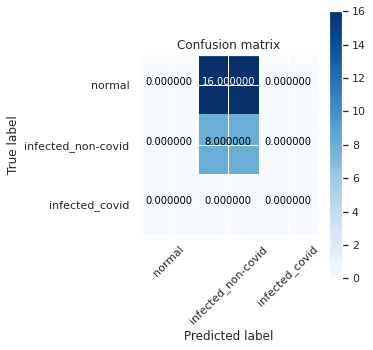

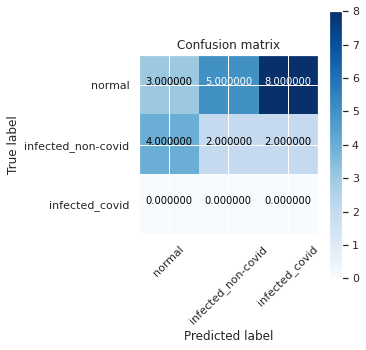

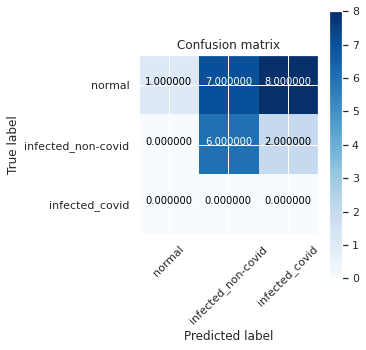

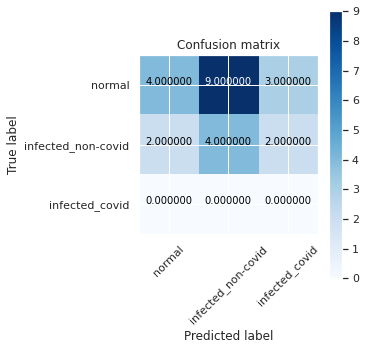

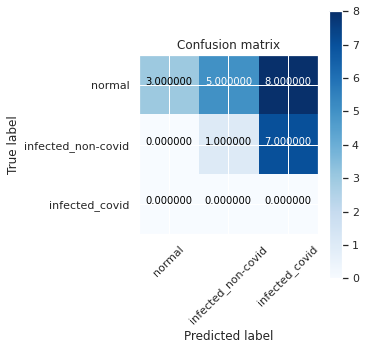

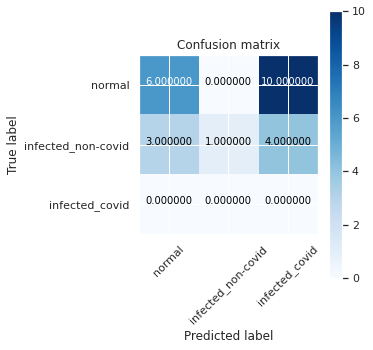

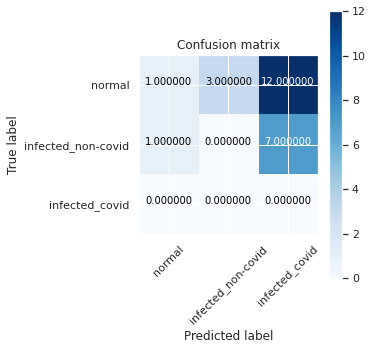

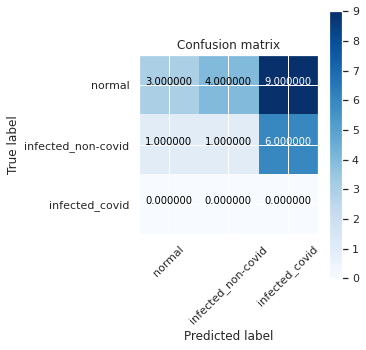

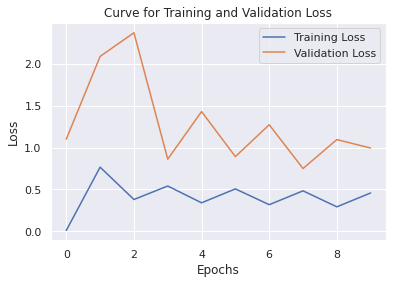

In [ ]:
# multiclass
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2,bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #input [1,150,150]
        self.conv1 = conv_block(1, 8)
        self.conv2 = conv_block(8, 16)
        self.conv3 = triple_conv(16, 32)
        self.conv4 = triple_conv(32, 64)
        self.conv5 = triple_conv(64, 128)
        self.conv6 = triple_conv(128, 256)
        self.conv7 = conv_block(256, 128,size=1)
        self.conv8 = conv_block(128, 256)
        self.conv9 = conv_block(256, 3)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(300, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.max_pool2d(x, 2)
        x = self.conv4(x)
        x = F.max_pool2d(x, 2)
        x = self.conv5(x)
        x = F.max_pool2d(x, 2)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1) 
        return output

def train(model, train_loader, optimizer, epoch, val_loader,device):
  train_loss_values = []
  val_loss_values = []
  running_loss = 0
  print_every = 100

  print('training now...')
  start = time.time()

  for e in range(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device),target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = F.nll_loss(output, torch.max(target, 1)[1])
      loss.backward()
      optimizer.step()
      # scheduler.step()
      running_loss += loss.item()

      if batch_idx % print_every == 0:
        model.eval()
        with torch.no_grad():
          valid_loss, accuracy = validation(model, val_loader,device)
          train_loss_values.append(running_loss/print_every)
          val_loss_values.append(valid_loss/len(val_loader))
          
          print("Epoch: {}/{} - ".format(e+1, epoch),"Training Loss: {:.3f} ".format(running_loss/print_every))
          running_loss=0
          
          model.train()

  print('Training Loss Values are: ', train_loss_values,'Validation Loss Values are: ', val_loss_values)
  fig, ax = plt.subplots()
  ax.plot(train_loss_values)
  ax.plot(val_loss_values)
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.set_title('Curve for Training and Validation Loss')
  ax.legend(['Training Loss', 'Validation Loss'])
  fig.savefig('model_losses_multiclass_complex.png')
  # ax.show()

  print(f"Run time: {(time.time() - start)/60:.3f} min")

def validation(model, val_loader, device):
    model.eval()
    correct = 0
    val_loss = 0

    confusion_matrix = torch.zeros(3, 3)

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device),target.to(device)
            output = model.forward(data)
            val_loss += F.nll_loss(output, torch.max(target,1)[1]).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(torch.max(target,1)[1].view_as(pred)).sum().item()

            for t, p in zip(target.view(-1), pred.view(-1)):
              confusion_matrix[t.long(), p.long()] += 1
    
    print(type(confusion_matrix))
    classes = ["normal", "infected_non-covid", "infected_covid"] 

    plt.figure(figsize=(5,5))
    plot_confusion_matrix(confusion_matrix, classes)

    accuracy = (100. * correct / len(val_loader.dataset))
    print("Validation loss: {}".format(val_loss / len(val_loader)))
    print('Validation set accuracy: ', accuracy, '%')
    
    return val_loss, accuracy     

def test(model, test_loader, device):
  model.eval() 
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device),target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, torch.max(target, 1)[1])  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(torch.max(target,1)[1].view_as(pred)).sum().item()
      
  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

def main():
  model = Net()
  optimizer = optim.Adadelta(model.parameters(), lr=1.0)
  # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
  device='cuda'
  model.to(device)
  train(model, train_loader, optimizer,  5, val_loader,device)
  torch.save(model, 'complex_model_multiclass.pth')
  test(model, test_loader,device)

main()

## Simple

training now...
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[ 0., 16.,  0.],
        [ 0.,  8.,  0.],
        [ 0.,  0.,  0.]])
Validation loss: 19.13910484313965
Validation set accuracy:  33.333333333333336 %
Epoch: 1/5 -  Training Loss: 0.011 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[ 0., 16.,  0.],
        [ 0.,  8.,  0.],
        [ 0.,  0.,  0.]])
Validation loss: 1.1012070178985596
Validation set accuracy:  33.333333333333336 %
Epoch: 1/5 -  Training Loss: 1.578 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[ 0., 16.,  0.],
        [ 0.,  8.,  0.],
        [ 0.,  0.,  0.]])
Validation loss: 1.1070349216461182
Validation set accuracy:  33.333333333333336 %
Epoch: 2/5 -  Training Loss: 0.675 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[ 0., 16.,  0.],
        [ 0.,  8.,  0.],
        [ 0.,  0.,  0.]])
Validation loss: 1.1201778650283813
Validation set accuracy:  33.3333333

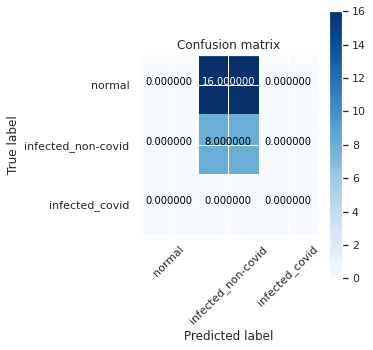

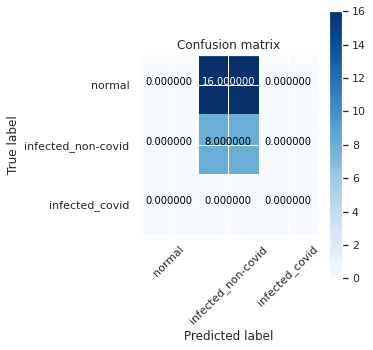

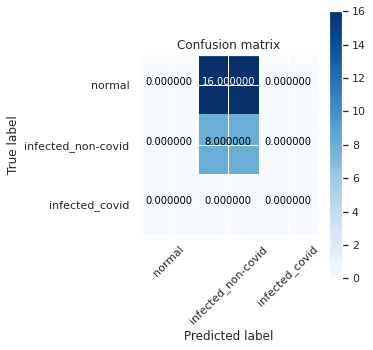

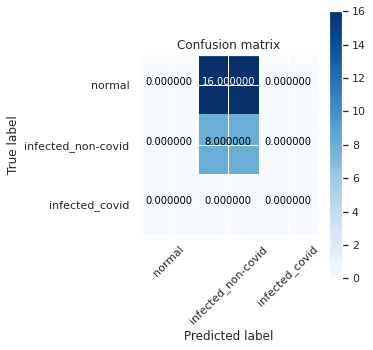

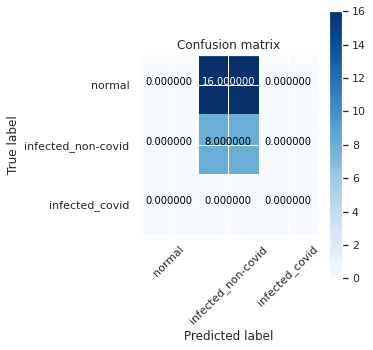

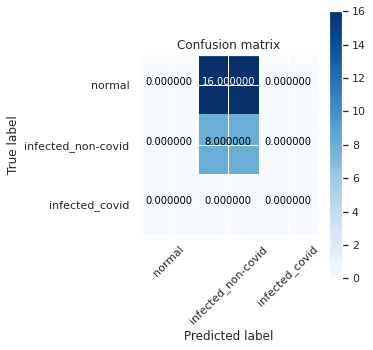

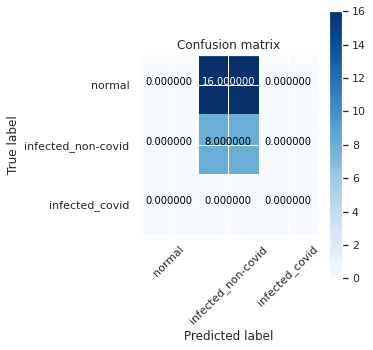

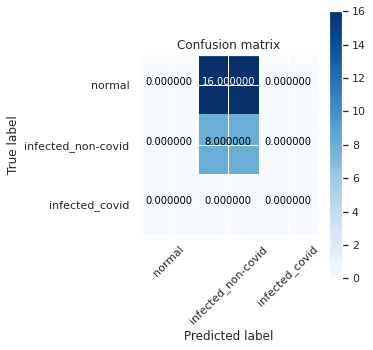

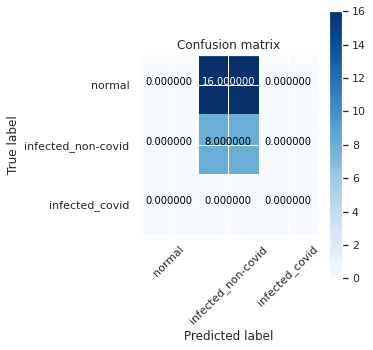

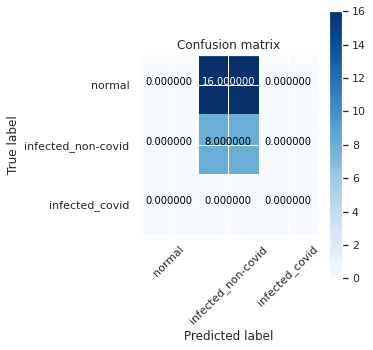

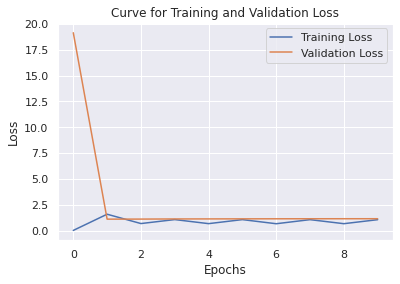

In [ ]:
# multiclass
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2D: 1 input channel, 32 output channels, 3 by 3 kernel, stride of 1
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # Conv2D: 1 input channel, 64 output channels, 3 by 3 kernel, stride of 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # fully connected layer with 128 outputs
        self.fc1 = nn.Linear(341056, 128)
        # fully connected layer with 3 outputs
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        # print("Input:", x.shape)
        x = self.conv1(x)
        # print("After conv1:", x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        # print("After conv2:", x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print("After max_pool2d:", x.shape)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        # print("After flatten:", x.shape)
        x = self.fc1(x)
        # print("After fc1:", x.shape)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # print("After fc2:", x.shape)
        output = F.log_softmax(x, dim=1) 
        # print("Output:", output.shape)
        return output


def train(model, train_loader, optimizer, epoch, val_loader,device):
  train_loss_values = []
  val_loss_values = []
  running_loss = 0
  print_every = 100

  print('training now...')
  start = time.time()

  for e in range(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device),target.to(device)
      optimizer.zero_grad()
      output = model.forward(data)
      loss = F.nll_loss(output, torch.max(target, 1)[1])
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

      if batch_idx % print_every == 0:
        model.eval()
        with torch.no_grad():
          valid_loss, accuracy = validation(model, val_loader,device)
          train_loss_values.append(running_loss/print_every)
          val_loss_values.append(valid_loss/len(val_loader))
          
          print("Epoch: {}/{} - ".format(e+1, epoch),"Training Loss: {:.3f} ".format(running_loss/print_every))
          running_loss=0
          
          model.train()
  
  print('Training Loss Values are: ', train_loss_values,'Validation Loss Values are: ', val_loss_values)
  fig, ax = plt.subplots()
  ax.plot(train_loss_values)
  ax.plot(val_loss_values)
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.set_title('Curve for Training and Validation Loss')
  ax.legend(['Training Loss', 'Validation Loss'])
  fig.savefig('model_losses_multiclass_simple.png')
  # ax.show()

  print(f"Run time: {(time.time() - start)/60:.3f} min")

def validation(model, val_loader, device):
    model.eval()
    correct = 0
    val_loss = 0

    confusion_matrix = torch.zeros(3, 3)

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device),target.to(device)
            output = model.forward(data)
            val_loss += F.nll_loss(output, torch.max(target,1)[1]).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(torch.max(target,1)[1].view_as(pred)).sum().item()

            for t, p in zip(target.view(-1), pred.view(-1)):
              confusion_matrix[t.long(), p.long()] += 1
    
    print(type(confusion_matrix))
    classes = ["normal", "infected_non-covid", "infected_covid"]  # infected_non-covid --> 0, infected_covid --> 1   

    plt.figure(figsize=(5,5))
    plot_confusion_matrix(confusion_matrix, classes)

    accuracy = (100. * correct / len(val_loader.dataset))
    print("Validation loss: {}".format(val_loss / len(val_loader)))
    print('Validation set accuracy: ', accuracy, '%')
    
    return val_loss, accuracy     

def test(model, test_loader, device):
  model.eval() 
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device),target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, torch.max(target, 1)[1])  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(torch.max(target,1)[1].view_as(pred)).sum().item()
      
  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))


def main():
  model = Net()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
  device='cuda'
  model.to(device)
  train(model, train_loader, optimizer, 5, val_loader,device)
  torch.save(model, 'simplemodel_multiclass.pth')
  test(model, test_loader, device)

main()